# Task 1

# Initial Comments

Only 40 rows? This data is extremely small to generalize.

But I'll be using 5-fold cross validation as I don't want my models to get lucky on a particular train-test split seed and do bad on the rest. Either way, since the size of the dataset is small, performing a CV on the test set would make sense for a more generalized result. Also stratifying for target label uniformity.

I'm also slightly confused because linear regression is a regression model, not a classification model. You could classify it using a linear regression model with a threshold of 0.5 to classify so I can try that. We could try a non-linear classifier like logistic regression and check as well

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score

# 1) load data from URL

url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSC87hYugbdg0_MbAhqVHaGSTk_-tEb_X_1YeXo6qzuz-bKm3Vo3gQd6m4IlZ5CAQMUUxfZrtCgbWYv/pub?output=csv"
data = pd.read_csv(url).iloc[:,1:]

data['target'].value_counts()

target
1    20
0    20
Name: count, dtype: int64

We have an equal distribution of classes so data balancing should not be necessary.

For KNNs, it would be better to first experiment and check which k value would be the most optimal. Since we also have 40 samples and we are using kFold, we can't use more than 32 samples as we are splitting dataset as 80% training and 20% test data => 80% of 40 = 32. We'd then select the best k value best on an average of accuracy and precision scores. The experimentation results are shown below :-

From the experiments, it seems like k=20 looks ideal for good accuracy and precision.

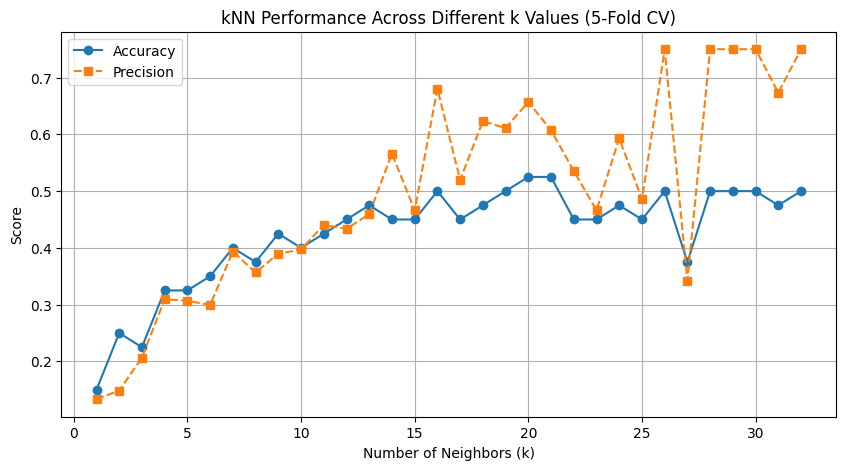

Best k: 20 - Accuracy: 0.5250, Precision: 0.6571


In [4]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# 2) Scale them. Most algorithms used here require scaling to ensure proper gradient optimization
# It's also to avoid certain features dominating the classification decision
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
k_values = range(1, 33)
results = {k: [] for k in k_values}

# 4) Training KNN models for experiments
for train_idx, test_idx in kf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=1) # zero-division to prevent warning
        # (zero-division argument was passed to avoid UndefinedMetricWarning. However, note that this cause a slight change in the final precision score result. However, the verdict is still the same.)
        results[k].append((acc, prec))

# 5) Aggregate results
avg_results = {k: np.mean(scores, axis=0) for k, scores in results.items()}

# Extract accuracy and precision
accuracies = [avg_results[k][0] for k in k_values]
precisions = [avg_results[k][1] for k in k_values]

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o', label='Accuracy', linestyle='-')
plt.plot(k_values, precisions, marker='s', label='Precision', linestyle='--')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Score")
plt.title("kNN Performance Across Different k Values (5-Fold CV)")
plt.legend()
plt.grid()
plt.show()

# Print best k
best_k = max(avg_results, key=lambda k: avg_results[k][0])
print(f"Best k: {best_k} - Accuracy: {avg_results[best_k][0]:.4f}, Precision: {avg_results[best_k][1]:.4f}")

In [5]:
# Load dataset
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSC87hYugbdg0_MbAhqVHaGSTk_-tEb_X_1YeXo6qzuz-bKm3Vo3gQd6m4IlZ5CAQMUUxfZrtCgbWYv/pub?output=csv"
data = pd.read_csv(url).iloc[:,1:]

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

models = {
        "Linear Regression": LinearRegression(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "SVM (RBF)": SVC(kernel='rbf', C=1.0),
        "SVM (Linear)": SVC(kernel='linear', C=1.0),
        "SVM (Poly)": SVC(kernel='poly', C=1.0),
        "kNN_20": KNeighborsClassifier(n_neighbors=20)
}


def infer_on_requested_models(X,y):   
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # K-Fold Cross Validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {name: [] for name in models.keys()}
    
    for train_idx, test_idx in kf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        for name, model in models.items():
            if name == "Linear Regression":
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_pred = (y_pred > 0.5).astype(int)  # We are thresholding at 0.5 probability here
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
            
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted', zero_division=1)
            results[name].append((acc, prec))
    
    # Aggregate results
    avg_results = {name: np.mean(scores, axis=0) for name, scores in results.items()}
    
    # Print evaluation
    print("\n--- Model Performance (K-Fold CV) ---")
    for name, (acc, prec) in avg_results.items():
        print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}")
    
    # Visualization
    model_names = list(avg_results.keys())
    accuracies = [avg_results[name][0] for name in model_names]
    
    plt.figure(figsize=(8,6))
    sns.barplot(x=model_names, y=accuracies, palette="viridis")
    plt.ylabel("Average Accuracy Score")
    plt.title("Model Performance (5-Fold Cross Validation)")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.show()


--- Model Performance (K-Fold CV) ---
Linear Regression - Accuracy: 0.2750, Precision: 0.2500
Logistic Regression - Accuracy: 0.2250, Precision: 0.1800
SVM (RBF) - Accuracy: 0.4250, Precision: 0.4090
SVM (Linear) - Accuracy: 0.2750, Precision: 0.2333
SVM (Poly) - Accuracy: 0.4500, Precision: 0.5357
kNN_20 - Accuracy: 0.5250, Precision: 0.6571


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


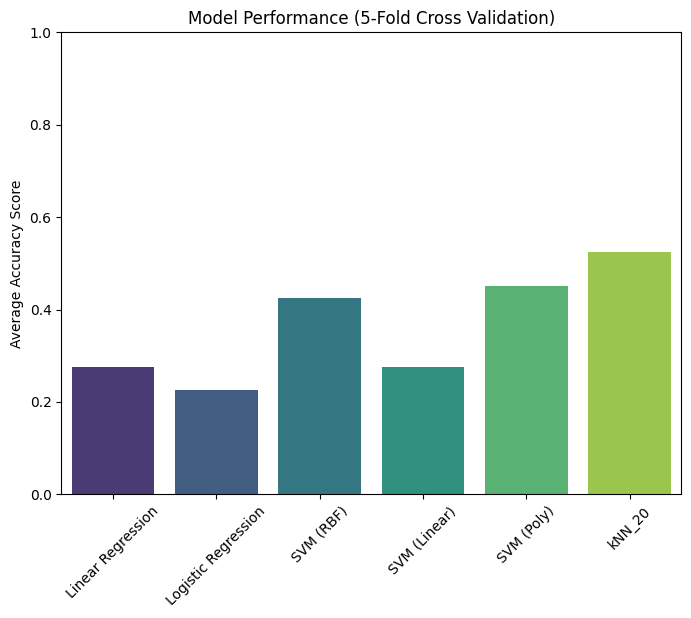

In [6]:
infer_on_requested_models(X,y)

Based on the results, I think we can deduce a trend here:-

Linear classifiers like linear regression, logistic regression and SVM with linear kernel seems to be performing poorly. This might suggest that the data's decision boundary is non-linear and better captured by non-linear models like SVMs with polynomial and rbf kernels. KNNs are not parameter-based but euclidean (distance-based) models so KNNs doing well might suggest there is some local patterns that KNNs are able to predict.

# Task 2

In [7]:
X_train.shape

(32, 320)

We have a total of 320 features (64 features in 5 bands).

## Univariate Feature Selection (UFS)

We will be using Univariate feature selection with F-test (for classification tasks, i.e, f_classif) for selecting the best features.

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=4)
selector.fit(X_scaled, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

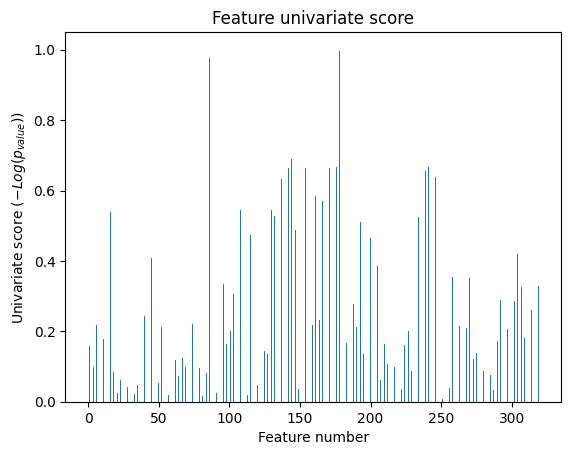

In [9]:
X_indices = np.arange(X_scaled.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

In [10]:
# Get the indices of the top 5 scores
top_5_indices = np.argsort(scores)[-5:][::-1]

# Print the indices and their corresponding scores
print("Top 5 feature indices:", top_5_indices)
print("Top 5 scores:", scores[top_5_indices])

Top 5 feature indices: [168 178  86 214 150]
Top 5 scores: [1.         0.9959601  0.97554226 0.90882525 0.85383976]


In [11]:
feature_names = data.iloc[:,:-1].columns  # Get feature names
top_5_features = feature_names[top_5_indices]

print("Top 5 feature names with UFS :", top_5_features.values)

Top 5 feature names with UFS : ['delta41' 'delta51' 'beta23' 'theta23' 'delta23']


Thus, we found the 5 most important features found via UFS

## Recursive Feature Elimination (RFE)

(Similar to UFS, the algorithm to calculate the features from RFE is listed in the appendix. These explanations would help to understand why the features arrived by these algorithms are so different)

Results in RFE have strong dependence with the model selected. Thus, we will try out the feature selection process with three models : Linear Regression, Logistic regression and Linear-kernel SVM

In [12]:
from sklearn.feature_selection import RFE

# Initialize models

# No need to mention linear regression's threshold here as we only need the coeffs and need not worry about the classification results.
linear_reg = LinearRegression()
log_reg = LogisticRegression(max_iter=1000)
svm = SVC(kernel='linear')

def apply_rfe(model, model_name):
    rfe = RFE(model, n_features_to_select=5)
    rfe.fit(X_scaled, y)
    selected_features = data.iloc[:,:-1].columns[rfe.support_]
    
    print(f"\nTop 5 features selected by RFE for {model_name}:")
    print(selected_features.tolist())

# Apply RFE to our 3 models
apply_rfe(linear_reg, "Linear Regression")
apply_rfe(log_reg, "Logistic Regression")
apply_rfe(svm, "Linear SVM")


Top 5 features selected by RFE for Linear Regression:
['alpha6', 'alpha58', 'beta10', 'beta29', 'delta58']

Top 5 features selected by RFE for Logistic Regression:
['beta44', 'delta19', 'delta60', 'theta1', 'theta23']

Top 5 features selected by RFE for Linear SVM:
['alpha37', 'beta43', 'theta58', 'theta61', 'theta62']


We can see that using RFE on different models' estimators yield different results. The reasoning is provided in the consolidated feature selection results.

## Principal Component Analysis (PCA)

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(X_scaled)

PCA(n_components=5)

In [14]:
loadings = np.abs(pca.components_)
feature_importance = np.sum(loadings, axis=0)
top_5_indices = np.argsort(feature_importance)[-5:][::-1]
top_5_features = data.iloc[:,:-1].columns[top_5_indices]

In [15]:
print("Top 5 features contributing most to PCA:")
print(top_5_features.tolist())

Top 5 features contributing most to PCA:
['alpha18', 'alpha17', 'delta27', 'delta24', 'delta14']


### Consolidated results of top 5 features from each feature selection algorithm

UFS : 'delta41' 'delta51' 'beta23' 'theta23' 'delta23'

RFE (Linear Regression) : 'alpha6', 'alpha58', 'beta10', 'beta29', 'delta58'

RFE (Logistic Regression) : 'beta44', 'delta19', 'delta60', 'theta1', 'theta23'

RFE (Linear-Kernel SVC) : 'alpha37', 'beta43', 'theta58', 'theta61', 'theta62'

PCA : 'alpha18', 'alpha17', 'delta27', 'delta24', 'delta14'

As you can see, there is very little overlap in the best 5 features based on my experiments. I wouldn't expect these to be similar either. The reasons why are mentioned below:-


* All of the algorithms used for feature selection (UFS, RFE and PCA) work differently under the hood.
* UFS checks for features with higher variance/correlation with the target variable.
* RFE iteratively removes features based on model estimates and thus, the features selected are highly dependent on the model used and this explains the high variability of the best 5 features across different models used in the RFE algorithm
* PCA checks for highest explained variance of each feature and does not have anything to do with the target labels.

So in short, the questions answered by each algorithm is different (and thus, the answers are different as well):-

* UFS : "Which individual features correlate most with the target?"
* RFE : "Which features improve model predictions the most?"
* PCA : "Which features best explain the variance in the dataset?"

# Task 1 experiments (which did not work out)

## Data augmentation

Since the dataset only has 40 rows, one idea would be to augment the dataset so that the model can generalize better and not overfit on the small data.

I have tried Random noise generation using samples from a gaussian distribution with zero mean and variance equal to that of the data

In [16]:
def gaussian_noise_augment(X, y, num_copies=1, scale_factor=0.1):
    
    feature_std = X.std(axis=0)
    augmented_X = [X]  
    augmented_y = [y]

    for _ in range(num_copies):
        noise = np.random.normal(loc=0, scale=scale_factor * feature_std, size=X.shape)
        X_noisy = X + noise
        augmented_X.append(X_noisy)
        augmented_y.append(y)

    return np.vstack(augmented_X), np.hstack(augmented_y)

# Example Usage
X_augmented, y_augmented = gaussian_noise_augment(X, y, num_copies=2, scale_factor=0.1)

print("Original X shape:", X.shape)
print("Augmented X shape:", X_augmented.shape)
print("Original y shape:", y.shape)
print("Augmented y shape:", y_augmented.shape)

Original X shape: (40, 320)
Augmented X shape: (120, 320)
Original y shape: (40,)
Augmented y shape: (120,)



--- Model Performance (K-Fold CV) ---
Linear Regression - Accuracy: 0.9750, Precision: 0.9800
Logistic Regression - Accuracy: 0.9500, Precision: 0.9543
SVM (RBF) - Accuracy: 0.5667, Precision: 0.5858
SVM (Linear) - Accuracy: 0.9667, Precision: 0.9723
SVM (Poly) - Accuracy: 0.5750, Precision: 0.7210
kNN_20 - Accuracy: 0.5250, Precision: 0.5303


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


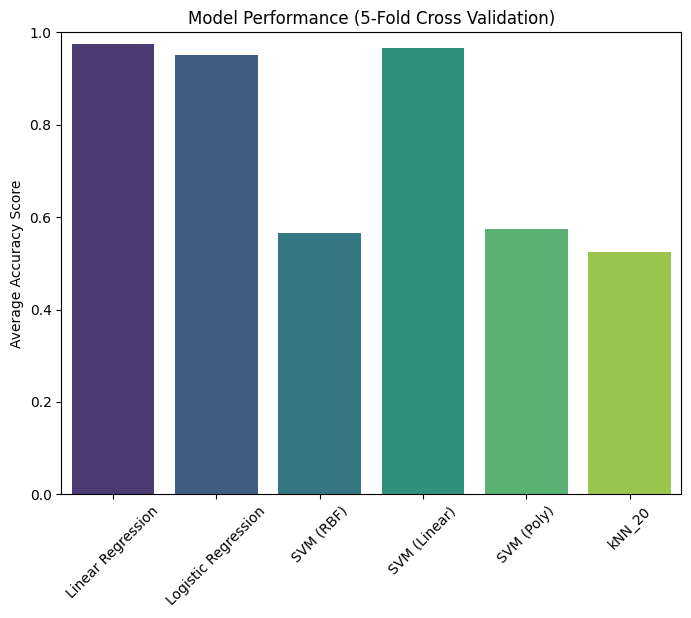

In [17]:
infer_on_requested_models(X_augmented, y_augmented)

Linear models score significantly high scores compared to the original dataset, which are clear signs of overfitting.

There is a slight increase in performance for non-linear kernel SVM models (most probably due to better generalization due to more data)

20-neighbor KNN performance has also gone down slightly.

## Modelling with only top n features from the mentioned feature selection techniques

I have also tried using models with only the top n features of the data (Experimented with values of n = 5, 10, 15, 20, 25). THe comprehensive analysis is available in the appendix and a consolidated review of the results is presented in the table below:-

|                     | UFS_5 | UFS_10 | UFS_15 | UFS_20 | UFS_25 | RFE_5 | RFE_10 | RFE_15 | RFE_20 | RFE_25 | PCA_5 | PCA_10 | PCA_15 | PCA_20 | PCA_25 |
| ------------------- | ----- | ------ | ------ | ------ | ------ | ----- | ------ | ------ | ------ | ------ | ----- | ------ | ------ | ------ | ------ |
| Linear Regression   | 0.525 | 0.575  | 0.525  | 0.375  | 0.475  | 0.675 | 0.7    | 0.75   | 0.675  | 0.625  | 0.275 | 0.3    | 0.25   | 0.225  | 0.4    |
| Logistic Regression | 0.525 | 0.55   | 0.525  | 0.55   | 0.525  | 0.65  | 0.675  | 0.625  | 0.6    | 0.6    | 0.25  | 0.275  | 0.225  | 0.2    | 0.2    |
| SVM (RBF)           | 0.6   | 0.525  | 0.5    | 0.45   | 0.475  | 0.575 | 0.525  | 0.45   | 0.375  | 0.35   | 0.475 | 0.45   | 0.45   | 0.425  | 0.425  |
| SVM (Linear)        | 0.525 | 0.525  | 0.5    | 0.525  | 0.55   | 0.65  | 0.725  | 0.65   | 0.6    | 0.625  | 0.325 | 0.275  | 0.2    | 0.25   | 0.275  |
| SVM (Poly)          | 0.55  | 0.525  | 0.525  | 0.525  | 0.525  | 0.525 | 0.475  | 0.45   | 0.475  | 0.45   | 0.45  | 0.475  | 0.475  | 0.475  | 0.45   |
| kNN_20              | 0.35  | 0.55   | 0.525  | 0.45   | 0.45   | 0.475 | 0.4    | 0.45   | 0.475  | 0.575  | 0.5   | 0.475  | 0.5    | 0.5    | 0.5    |

Thus, from the results, we can see that we can use the following pipeline to classify neural states of the given data:-

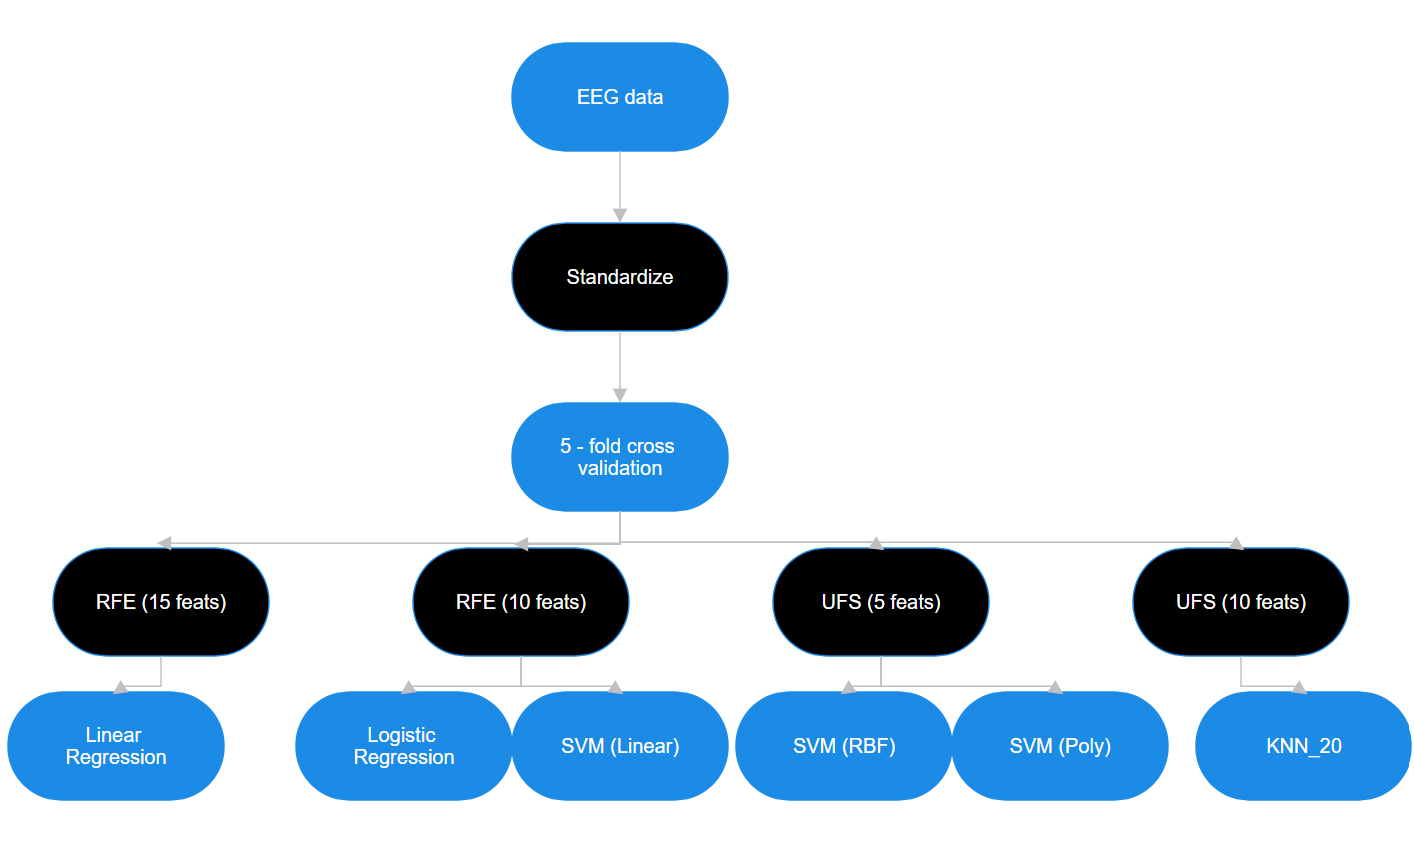

However, these results are only based on 40 rows of data provided in the original dataset. So I suspect these results might overfit on new data and thus did not include it in the original task.

# Appendix

## Modelling with top n features : comprehensive analysis

In [22]:
# Define feature selection methods
def select_features(X, y, method, n_features):
    if method == "UFS":
        selector = SelectKBest(score_func=f_classif, k=n_features)
        X_selected = selector.fit_transform(X, y)
    
    elif method == "RFE":
        base_model = LogisticRegression(max_iter=1000)
        selector = RFE(base_model, n_features_to_select=n_features)
        X_selected = selector.fit_transform(X, y)

    elif method == "PCA":
        pca = PCA(n_components=n_features)
        X_selected = pca.fit_transform(X)

    return X_selected

In [23]:
# Initialize results storage
table_results = pd.DataFrame(index=models.keys())

# Define evaluation function
def evaluate_models(X, y, feature_selection_method):
    global table_results
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for n_features in [5, 10, 15, 20, 25]:
        print(f"\n=== Feature Selection: {feature_selection_method} | Top {n_features} Features ===")
        
        X_selected = select_features(X, y, feature_selection_method, n_features)
        results = {name: [] for name in models.keys()}

        for train_idx, test_idx in kf.split(X_selected, y):
            X_train, X_test = X_selected[train_idx], X_selected[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            for name, model in models.items():
                if name == "Linear Regression":
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    y_pred = (y_pred > 0.5).astype(int)
                else:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)

                acc = accuracy_score(y_test, y_pred)
                results[name].append(acc)

        # Aggregate results
        avg_results = {name: np.mean(scores) for name, scores in results.items()}

        # Store results in table
        col_name = f"{feature_selection_method}_{n_features}"
        table_results[col_name] = [avg_results[name] for name in models.keys()]

# Run evaluations
for method in ["UFS", "RFE", "PCA"]:
    evaluate_models(X_scaled, y, method)

# Save results to CSV
table_results.to_csv("model_performance_results.csv")
print("Results saved to 'model_performance_results.csv'")

# Display table
print(table_results)


=== Feature Selection: UFS | Top 5 Features ===

=== Feature Selection: UFS | Top 10 Features ===

=== Feature Selection: UFS | Top 15 Features ===

=== Feature Selection: UFS | Top 20 Features ===

=== Feature Selection: UFS | Top 25 Features ===

=== Feature Selection: RFE | Top 5 Features ===

=== Feature Selection: RFE | Top 10 Features ===

=== Feature Selection: RFE | Top 15 Features ===

=== Feature Selection: RFE | Top 20 Features ===

=== Feature Selection: RFE | Top 25 Features ===

=== Feature Selection: PCA | Top 5 Features ===

=== Feature Selection: PCA | Top 10 Features ===

=== Feature Selection: PCA | Top 15 Features ===

=== Feature Selection: PCA | Top 20 Features ===

=== Feature Selection: PCA | Top 25 Features ===
Results saved to 'model_performance_results.csv'
                     UFS_5  UFS_10  UFS_15  UFS_20  UFS_25  RFE_5  RFE_10  \
Linear Regression    0.525   0.575   0.525   0.375   0.475  0.675   0.700   
Logistic Regression  0.525   0.550   0.525   0.550


=== Feature Selection: UFS | Top 5 Features ===
Linear Regression - Accuracy: 0.5250, Precision: 0.6205
Logistic Regression - Accuracy: 0.5250, Precision: 0.6343
SVM (RBF) - Accuracy: 0.6000, Precision: 0.7786
SVM (Linear) - Accuracy: 0.5250, Precision: 0.6571
SVM (Poly) - Accuracy: 0.5500, Precision: 0.7643
kNN_20 - Accuracy: 0.3500, Precision: 0.3833


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


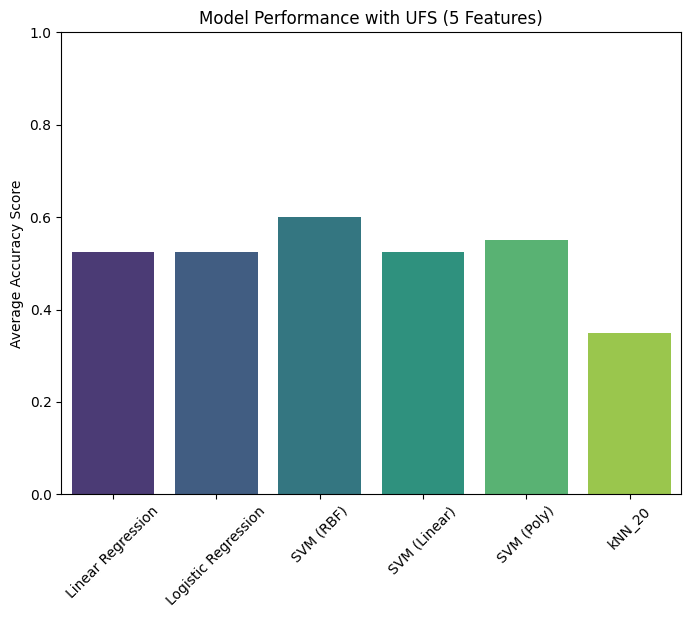


=== Feature Selection: UFS | Top 10 Features ===
Linear Regression - Accuracy: 0.5750, Precision: 0.6067
Logistic Regression - Accuracy: 0.5500, Precision: 0.5400
SVM (RBF) - Accuracy: 0.5250, Precision: 0.6071
SVM (Linear) - Accuracy: 0.5250, Precision: 0.6343
SVM (Poly) - Accuracy: 0.5250, Precision: 0.7571
kNN_20 - Accuracy: 0.5500, Precision: 0.6033


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


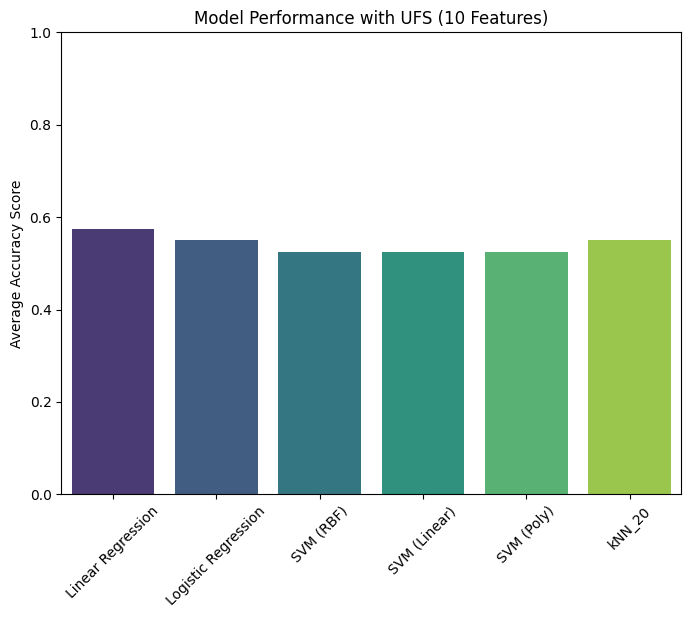


=== Feature Selection: UFS | Top 15 Features ===


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Linear Regression - Accuracy: 0.5250, Precision: 0.5267
Logistic Regression - Accuracy: 0.5250, Precision: 0.5100
SVM (RBF) - Accuracy: 0.5000, Precision: 0.5195
SVM (Linear) - Accuracy: 0.5000, Precision: 0.4829
SVM (Poly) - Accuracy: 0.5250, Precision: 0.7571
kNN_20 - Accuracy: 0.5250, Precision: 0.6738


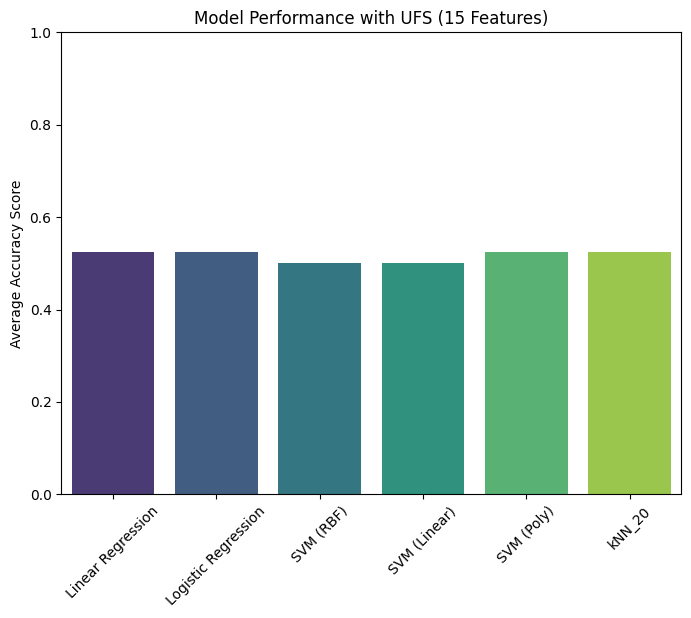


=== Feature Selection: UFS | Top 20 Features ===
Linear Regression - Accuracy: 0.3750, Precision: 0.3262
Logistic Regression - Accuracy: 0.5500, Precision: 0.5195
SVM (RBF) - Accuracy: 0.4500, Precision: 0.4357
SVM (Linear) - Accuracy: 0.5250, Precision: 0.5095
SVM (Poly) - Accuracy: 0.5250, Precision: 0.7571
kNN_20 - Accuracy: 0.4500, Precision: 0.5600


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


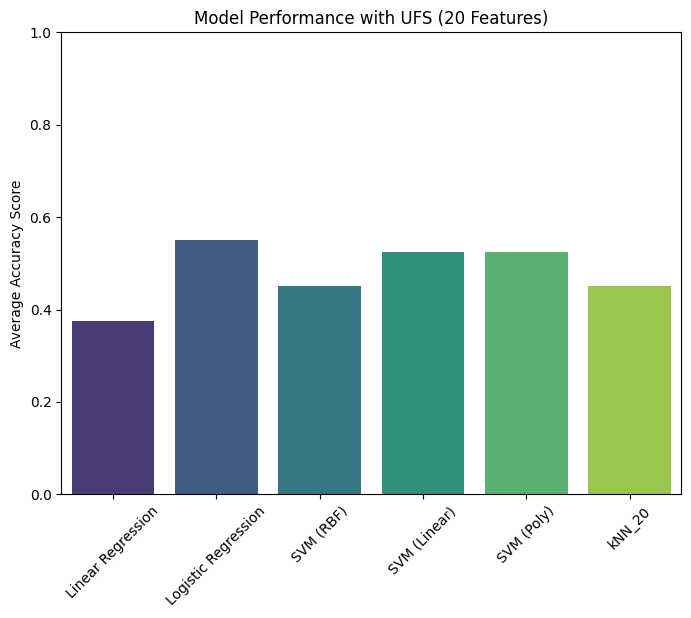

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)



=== Feature Selection: UFS | Top 25 Features ===
Linear Regression - Accuracy: 0.4750, Precision: 0.4733
Logistic Regression - Accuracy: 0.5250, Precision: 0.4929
SVM (RBF) - Accuracy: 0.4750, Precision: 0.4929
SVM (Linear) - Accuracy: 0.5500, Precision: 0.5195
SVM (Poly) - Accuracy: 0.5250, Precision: 0.7571
kNN_20 - Accuracy: 0.4500, Precision: 0.5500


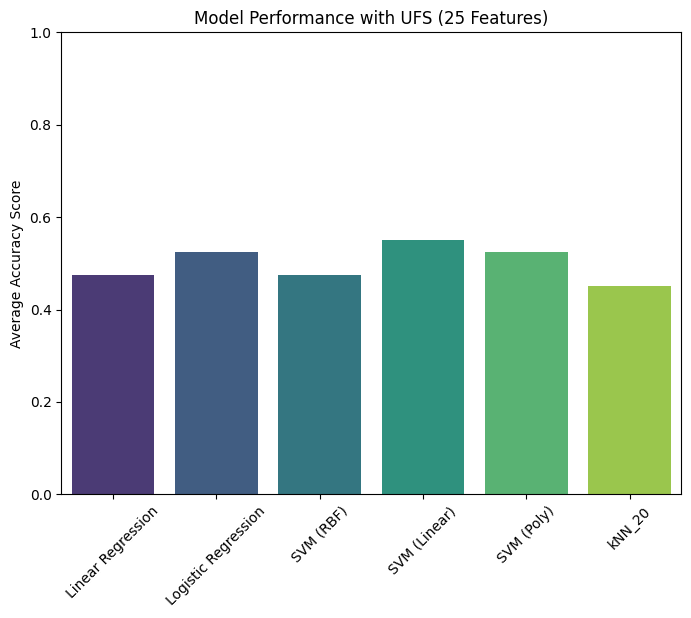


=== Feature Selection: RFE | Top 5 Features ===
Linear Regression - Accuracy: 0.6750, Precision: 0.6967
Logistic Regression - Accuracy: 0.6500, Precision: 0.6833
SVM (RBF) - Accuracy: 0.5750, Precision: 0.6238
SVM (Linear) - Accuracy: 0.6500, Precision: 0.7005
SVM (Poly) - Accuracy: 0.5250, Precision: 0.6571
kNN_20 - Accuracy: 0.4750, Precision: 0.5600


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


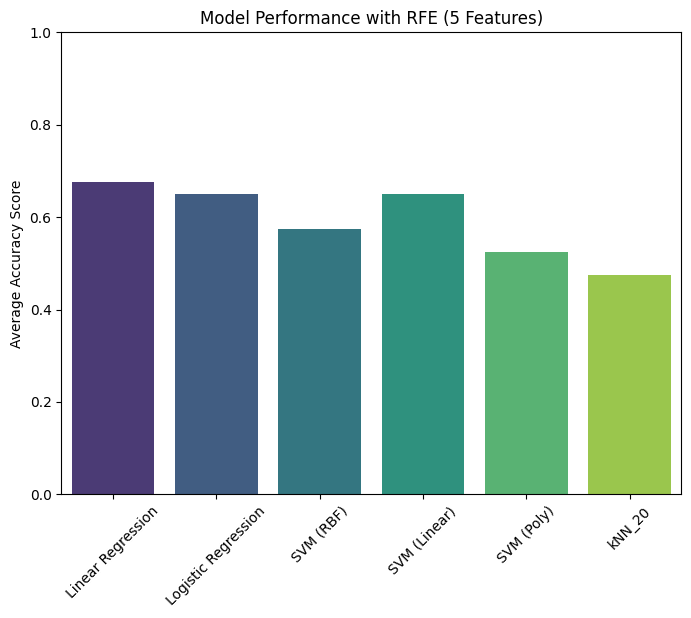


=== Feature Selection: RFE | Top 10 Features ===
Linear Regression - Accuracy: 0.7000, Precision: 0.7167
Logistic Regression - Accuracy: 0.6750, Precision: 0.6933
SVM (RBF) - Accuracy: 0.5250, Precision: 0.5767
SVM (Linear) - Accuracy: 0.7250, Precision: 0.7767
SVM (Poly) - Accuracy: 0.4750, Precision: 0.6429
kNN_20 - Accuracy: 0.4000, Precision: 0.3495


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


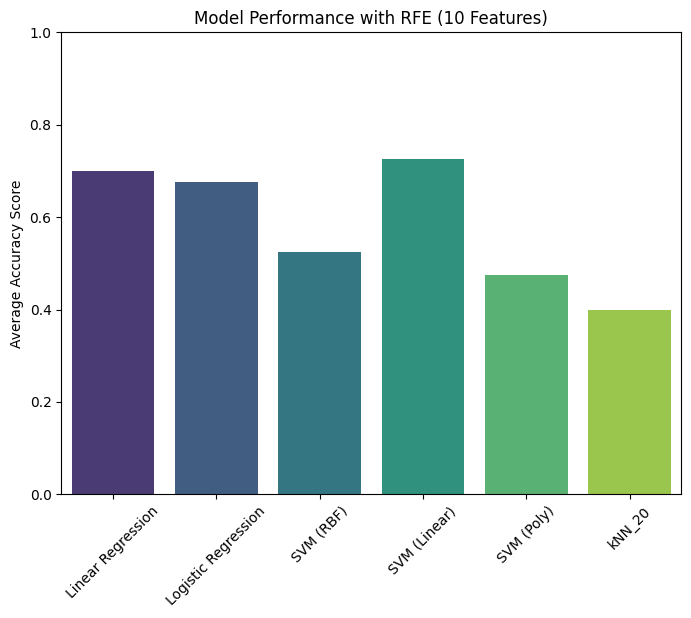


=== Feature Selection: RFE | Top 15 Features ===
Linear Regression - Accuracy: 0.7500, Precision: 0.7933
Logistic Regression - Accuracy: 0.6250, Precision: 0.6433
SVM (RBF) - Accuracy: 0.4500, Precision: 0.4662
SVM (Linear) - Accuracy: 0.6500, Precision: 0.6733
SVM (Poly) - Accuracy: 0.4500, Precision: 0.5357
kNN_20 - Accuracy: 0.4500, Precision: 0.4357


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


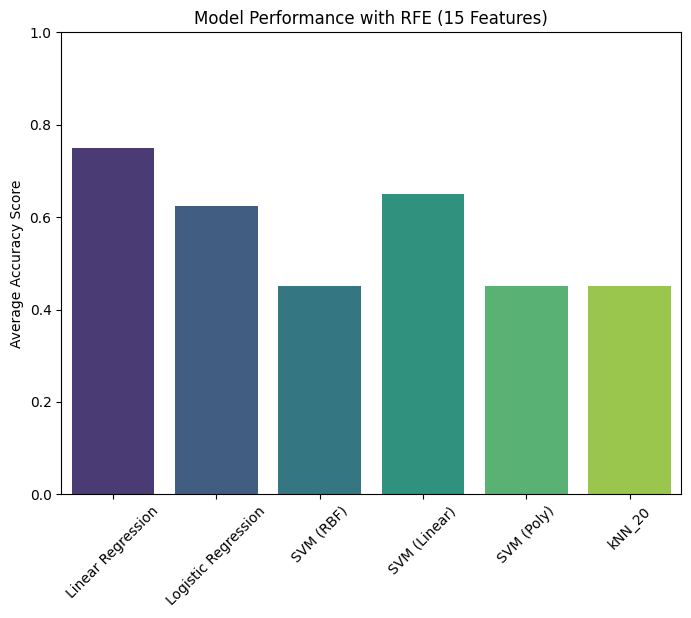


=== Feature Selection: RFE | Top 20 Features ===
Linear Regression - Accuracy: 0.6750, Precision: 0.7100
Logistic Regression - Accuracy: 0.6000, Precision: 0.6200
SVM (RBF) - Accuracy: 0.3750, Precision: 0.3700
SVM (Linear) - Accuracy: 0.6000, Precision: 0.6833
SVM (Poly) - Accuracy: 0.4750, Precision: 0.5124
kNN_20 - Accuracy: 0.4750, Precision: 0.5429


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


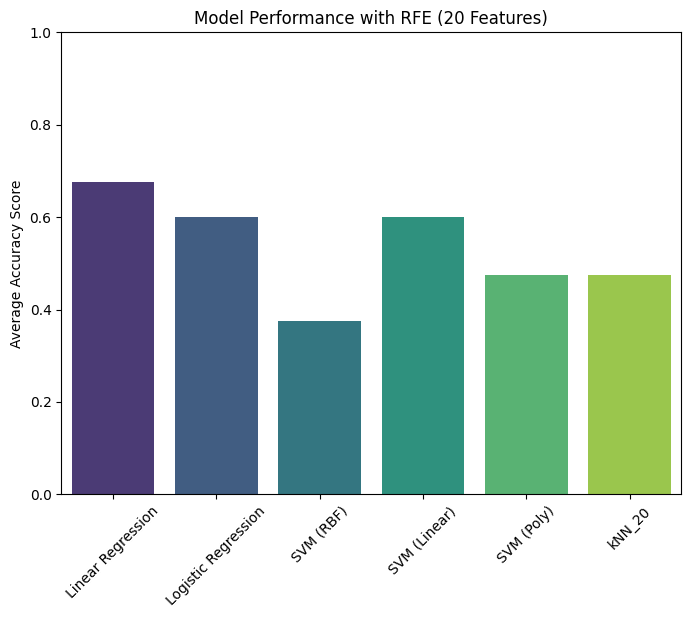


=== Feature Selection: RFE | Top 25 Features ===
Linear Regression - Accuracy: 0.6250, Precision: 0.6467
Logistic Regression - Accuracy: 0.6000, Precision: 0.6033
SVM (RBF) - Accuracy: 0.3500, Precision: 0.3190
SVM (Linear) - Accuracy: 0.6250, Precision: 0.6300
SVM (Poly) - Accuracy: 0.4500, Precision: 0.4857
kNN_20 - Accuracy: 0.5750, Precision: 0.7300


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


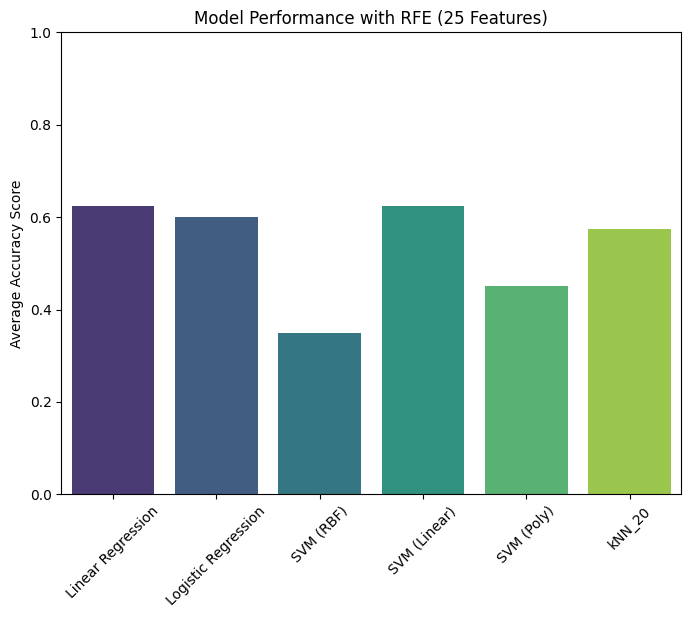


=== Feature Selection: PCA | Top 5 Features ===
Linear Regression - Accuracy: 0.2750, Precision: 0.2095
Logistic Regression - Accuracy: 0.2500, Precision: 0.1795
SVM (RBF) - Accuracy: 0.4750, Precision: 0.4733
SVM (Linear) - Accuracy: 0.3250, Precision: 0.2595
SVM (Poly) - Accuracy: 0.4500, Precision: 0.5662
kNN_20 - Accuracy: 0.5000, Precision: 0.6500


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


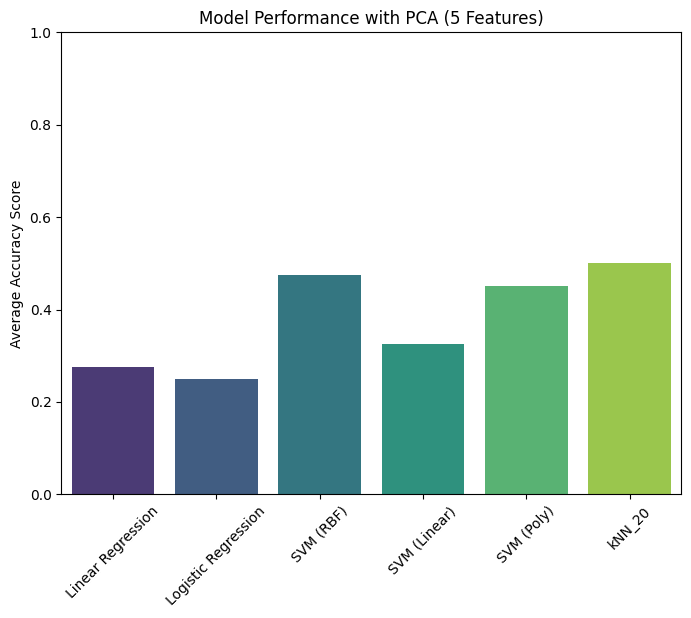


=== Feature Selection: PCA | Top 10 Features ===
Linear Regression - Accuracy: 0.3000, Precision: 0.2800
Logistic Regression - Accuracy: 0.2750, Precision: 0.2667
SVM (RBF) - Accuracy: 0.4500, Precision: 0.4162
SVM (Linear) - Accuracy: 0.2750, Precision: 0.2633
SVM (Poly) - Accuracy: 0.4750, Precision: 0.5929
kNN_20 - Accuracy: 0.4750, Precision: 0.5405


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


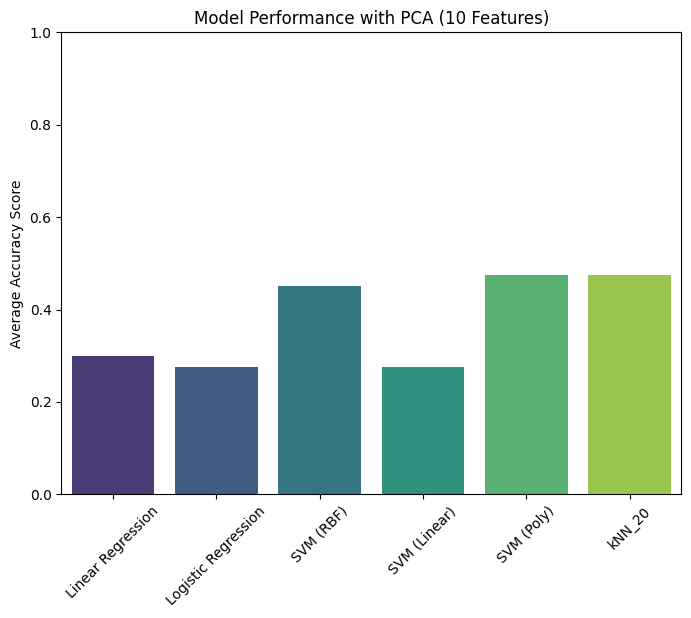


=== Feature Selection: PCA | Top 15 Features ===
Linear Regression - Accuracy: 0.2500, Precision: 0.1895
Logistic Regression - Accuracy: 0.2250, Precision: 0.1862
SVM (RBF) - Accuracy: 0.4500, Precision: 0.4357
SVM (Linear) - Accuracy: 0.2000, Precision: 0.1567
SVM (Poly) - Accuracy: 0.4750, Precision: 0.5929
kNN_20 - Accuracy: 0.5000, Precision: 0.6500


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


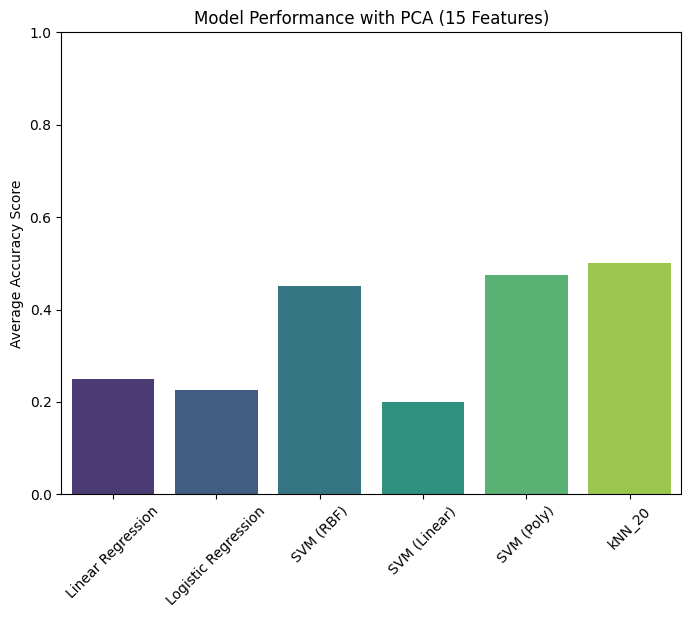


=== Feature Selection: PCA | Top 20 Features ===
Linear Regression - Accuracy: 0.2250, Precision: 0.1900
Logistic Regression - Accuracy: 0.2000, Precision: 0.1767
SVM (RBF) - Accuracy: 0.4250, Precision: 0.4090
SVM (Linear) - Accuracy: 0.2500, Precision: 0.2200
SVM (Poly) - Accuracy: 0.4750, Precision: 0.5929
kNN_20 - Accuracy: 0.5000, Precision: 0.6500


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


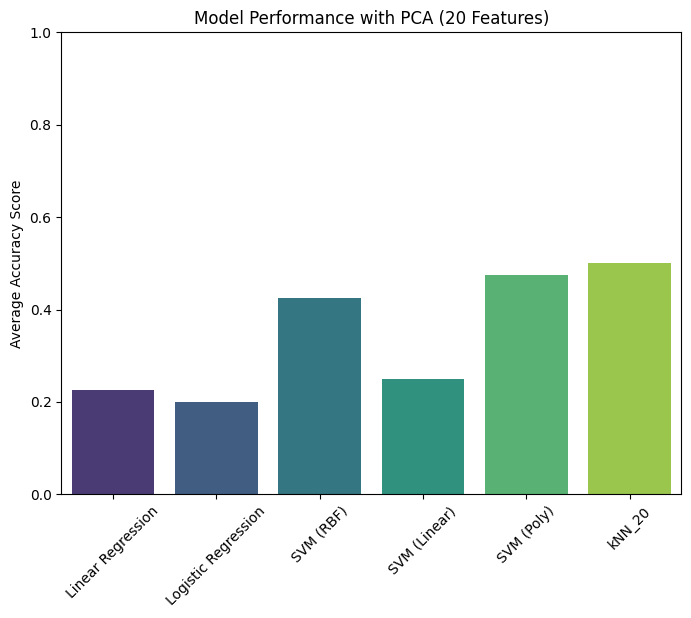


=== Feature Selection: PCA | Top 25 Features ===
Linear Regression - Accuracy: 0.4000, Precision: 0.3529
Logistic Regression - Accuracy: 0.2000, Precision: 0.1567
SVM (RBF) - Accuracy: 0.4250, Precision: 0.4090
SVM (Linear) - Accuracy: 0.2750, Precision: 0.2400
SVM (Poly) - Accuracy: 0.4500, Precision: 0.5357
kNN_20 - Accuracy: 0.5000, Precision: 0.6500


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


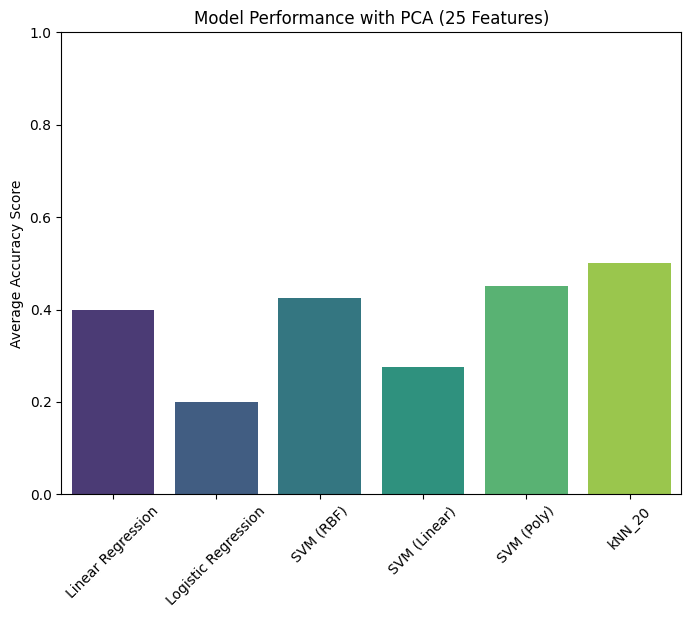

In [26]:
# Define evaluation function
def evaluate_models(X, y, feature_selection_method):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for n_features in [5, 10, 15, 20, 25]:
        print(f"\n=== Feature Selection: {feature_selection_method} | Top {n_features} Features ===")
        
        X_selected = select_features(X, y, feature_selection_method, n_features)
        results = {name: [] for name in models.keys()}

        for train_idx, test_idx in kf.split(X_selected, y):
            X_train, X_test = X_selected[train_idx], X_selected[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            for name, model in models.items():
                if name == "Linear Regression":
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    y_pred = (y_pred > 0.5).astype(int)
                else:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)

                acc = accuracy_score(y_test, y_pred)
                prec = precision_score(y_test, y_pred, average='weighted', zero_division=1)
                results[name].append((acc, prec))

        # Aggregate results
        avg_results = {name: np.mean(scores, axis=0) for name, scores in results.items()}

        # Print evaluation
        for name, (acc, prec) in avg_results.items():
            print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}")

        # Visualization
        model_names = list(avg_results.keys())
        accuracies = [avg_results[name][0] for name in model_names]

        plt.figure(figsize=(8, 6))
        sns.barplot(x=model_names, y=accuracies, palette="viridis")
        plt.ylabel("Average Accuracy Score")
        plt.title(f"Model Performance with {feature_selection_method} ({n_features} Features)")
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
        plt.show()

# Run evaluations
for method in ["UFS", "RFE", "PCA"]:
    evaluate_models(X_scaled, y, method)